# <center>Modelo de detecção de quedas usando CNN</center>

## Pré processamento dos dados

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
full_dataset = pd.read_csv('full_dataset.csv', index_col=0)
full_dataset.head()

,video_name,tag,start,end
0,Coffee_room_01-video (25).avi,fall,75,175
1,Coffee_room_02-video (56).avi,fall,250,350
2,Home_02-video (57).avi,nonfall,100,200
3,Home_02-video (59).avi,nonfall,100,200
4,Coffee_room_01-video (38).avi,fall,175,275


In [3]:
batch_size = 64
img_height = 224
img_width = 224
EPOCHS = 10
IMG_SHAPE = (img_width, img_height) + (3,)
data_dir = "dataset"

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 188 files belonging to 2 classes.
Using 151 files for training.
Found 188 files belonging to 2 classes.
Using 37 files for validation.


In [5]:
# Classes do modelo
class_names = train_ds.class_names
print(class_names)

['fall', 'nonfall']


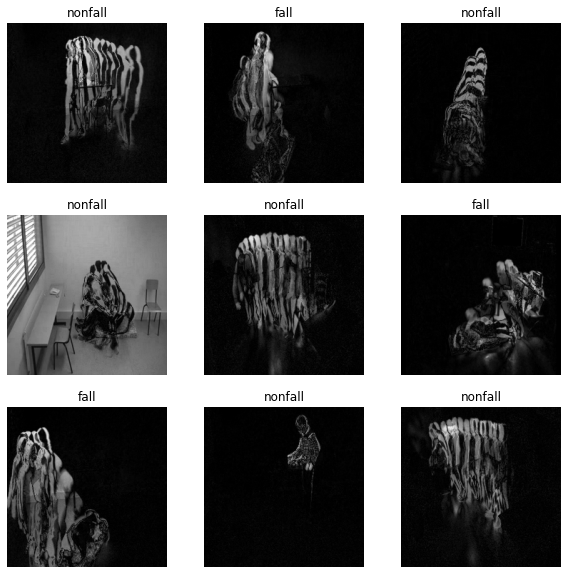

In [6]:
# Algumas imagens
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Tamanho do lote com as amostras e os seus rótulos
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [8]:
# AUTOTUNE para aumentar a performance durante a estapa de treinamento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

## Etapa de Classificação

### Definição do classificador

In [10]:
# Camada de entrada do modelo
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# Carregamento do modelo pré-treinado usando arquitetura da MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
# Definição da arquitetura com a cabeça de classificação
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32,activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
# Resumo do modelo gerado
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0     

### Treinamento do Modelo

In [14]:
# Definição da função callback para salvar o modelo com melhor acurácia na validação
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Treinamento do modelo com ajuste aos dados
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
3/3 [==============================] - 10s 2s/step - loss: 2.4154 - accuracy: 0.5166 - val_loss: 0.6073 - val_accuracy: 0.6757
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 0.6571 - accuracy: 0.5762 - val_loss: 0.5848 - val_accuracy: 0.7027
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.5761 - accuracy: 0.7086 - val_loss: 0.5189 - val_accuracy: 0.7568
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.4952 - accuracy: 0.7748 - val_loss: 0.3626 - val_accuracy: 0.9189
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 0.3979 - accuracy: 0.8212 - val_loss: 0.3122 - val_accuracy: 0.8919
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 0.3094 - accuracy: 0.8675 - val_loss: 0.4052 - val_accuracy: 0.9189
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0.2420 - accuracy: 0.9205 - val_loss: 0.3599 - val_accuracy: 0.9189
Epoch 8/10
3/3 [========================

## Resultado do treinamento

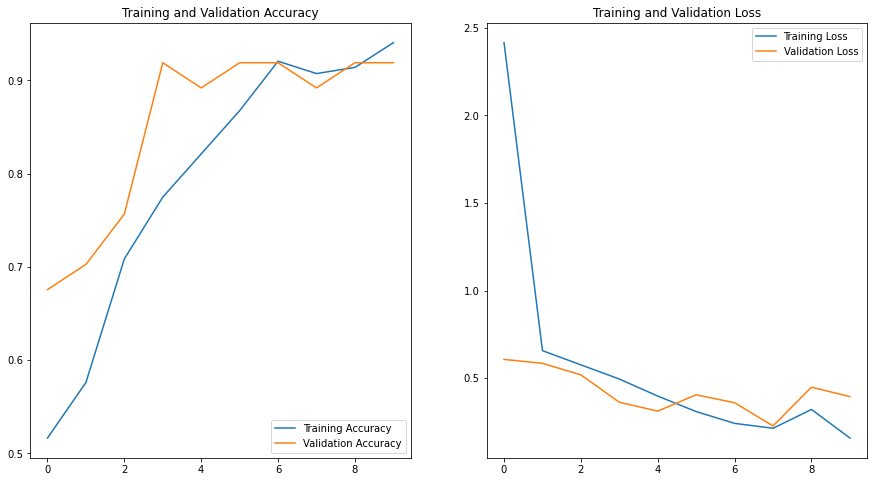

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()